### Import Libraries

In [116]:
import yfinance as yf
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns
from pypfopt import plotting
#import cvxpy 
import pypfopt.plotting as plotting
from datetime import datetime, timedelta
from fredapi import Fred
from dotenv import load_dotenv
import os
load_dotenv()
#import warnings
# warnings.filterwarnings("ignore")

True

In [106]:
API_KEY = os.getenv("API_KEY")
fred = Fred(api_key=API_KEY)
cpi_data = fred.get_series('CPIAUCSL')  # This is the FRED ID for CPI

start_date = "2015-01-01"
end_date = "2025-05-01"


# Optional: convert to DataFrame
cpi_df = cpi_data.to_frame(name='CPI')
cpi_df.index.name = 'Date'
cpi_df = cpi_df[(cpi_df.index >= start_date) & (cpi_df.index <= end_date)]
# cpi_normalized = cpi_df / cpi_df.iloc[0]

print(cpi_df)

                CPI
Date               
2015-01-01  234.747
2015-02-01  235.342
2015-03-01  235.976
2015-04-01  236.222
2015-05-01  237.001
...             ...
2024-12-01  317.603
2025-01-01  319.086
2025-02-01  319.775
2025-03-01  319.615
2025-04-01  320.321

[124 rows x 1 columns]


In [107]:
#USCAD currency, gold, S&P 500, long term tradable treasury bond, bitcoin
# tickers = ['USDCAD=X', 'GLD', '^GSPC', 'TLT', 'BTC-USD']
tickers = ['GC=F', '^GSPC', 'BTC-USD']

adj_close_df = pd.DataFrame()

for ticker in tickers:
    data = yf.download(ticker, start=start_date, end=end_date, auto_adjust=False)
    adj_close_df[ticker] = data['Adj Close']

adj_close_df.rename(columns={'GC=F': 'Gold', '^GSPC': 'SP500', 'BTC-USD': 'Bitcoin'}, inplace=True)


adj_close_df = adj_close_df.resample('MS').first()

print(adj_close_df)





[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

                   Gold        SP500        Bitcoin
Date                                               
2015-01-01  1186.000000  2058.199951     315.032013
2015-02-01  1276.199951  2020.849976     238.229004
2015-03-01  1207.699951  2117.389893     275.670013
2015-04-01  1208.099976  2059.689941     247.272003
2015-05-01  1174.500000  2108.290039     232.078995
...                 ...          ...            ...
2024-12-01  2634.899902  6047.149902   95865.304688
2025-01-01  2658.899902  5868.549805   96886.875000
2025-02-01  2833.899902  5994.569824  101405.421875
2025-03-01  2890.199951  5849.720215   86065.671875
2025-04-01  3118.899902  5633.069824   85169.171875

[124 rows x 3 columns]


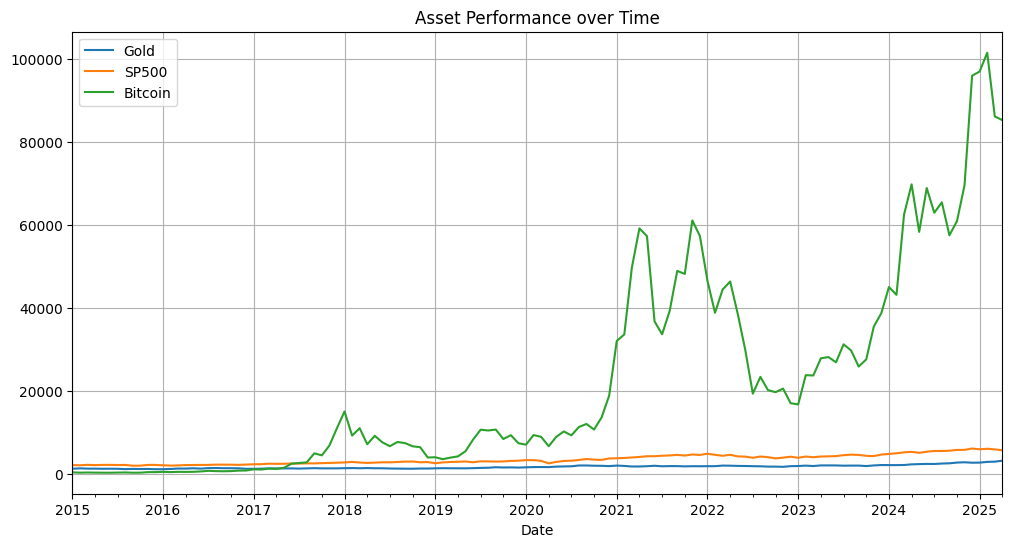

In [108]:
adj_close_df[['Gold', 'SP500', 'Bitcoin']].plot(figsize=(12,6), title="Asset Performance over Time")
plt.grid(True)
plt.show()

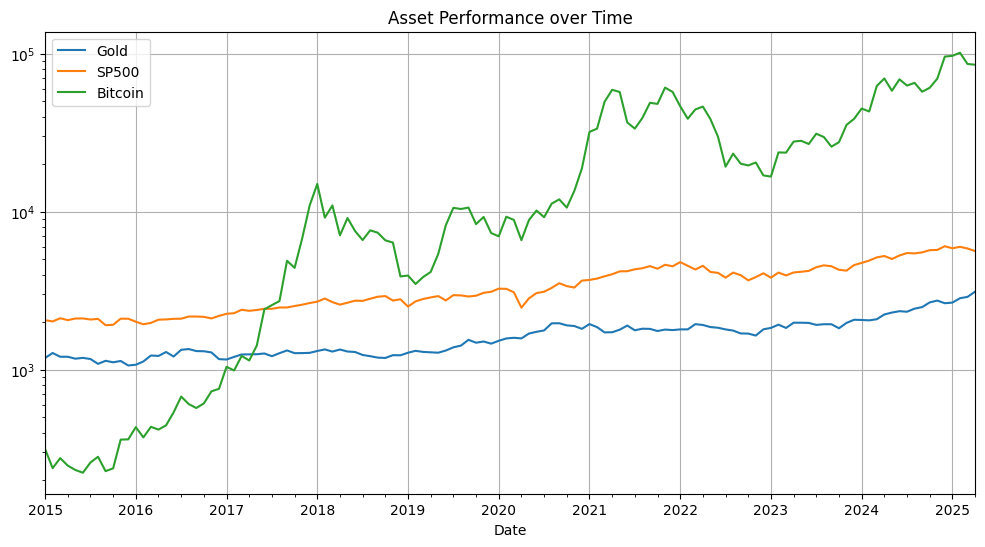

In [109]:
adj_close_df[['Gold', 'SP500', 'Bitcoin']].plot(figsize=(12,6), title="Asset Performance over Time")
plt.grid(True)
plt.yscale('log')
plt.show()


### Calculate Returns

In [110]:
#log of row divided by previous row
asset_returns = np.log(adj_close_df / adj_close_df.shift(1)).dropna()

cpi_returns = cpi_df.pct_change().dropna()


# print(asset_returns)
# print(cpi_returns)

# assets_normalized = adj_close_df / adj_close_df.iloc[0]
returns = pd.merge(cpi_returns, asset_returns, how='inner', on='Date')

print(returns)

                 CPI      Gold     SP500   Bitcoin
Date                                              
2015-02-01  0.002535  0.073301 -0.018314 -0.279442
2015-03-01  0.002694 -0.055169  0.046666  0.145972
2015-04-01  0.001042  0.000331 -0.027629 -0.108716
2015-05-01  0.003298 -0.028206  0.023322 -0.063411
2015-06-01  0.002768  0.011681  0.001630 -0.040238
...              ...       ...       ...       ...
2024-12-01  0.003647 -0.038602  0.054081  0.321870
2025-01-01  0.004669  0.009067 -0.029980  0.010600
2025-02-01  0.002159  0.063741  0.021246  0.045582
2025-03-01 -0.000500  0.019672 -0.024460 -0.164016
2025-04-01  0.002209  0.076155 -0.037739 -0.010471

[123 rows x 4 columns]


              CPI      Gold     SP500   Bitcoin
CPI      1.000000 -0.019876  0.215157 -0.011663
Gold    -0.019876  1.000000  0.051284  0.078385
SP500    0.215157  0.051284  1.000000  0.335934
Bitcoin -0.011663  0.078385  0.335934  1.000000


<Figure size 1200x600 with 0 Axes>

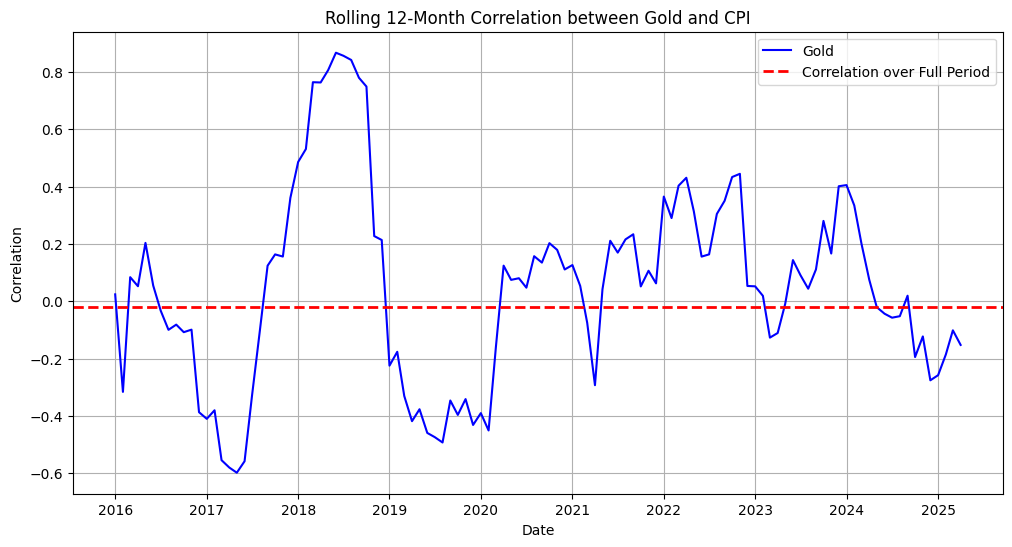

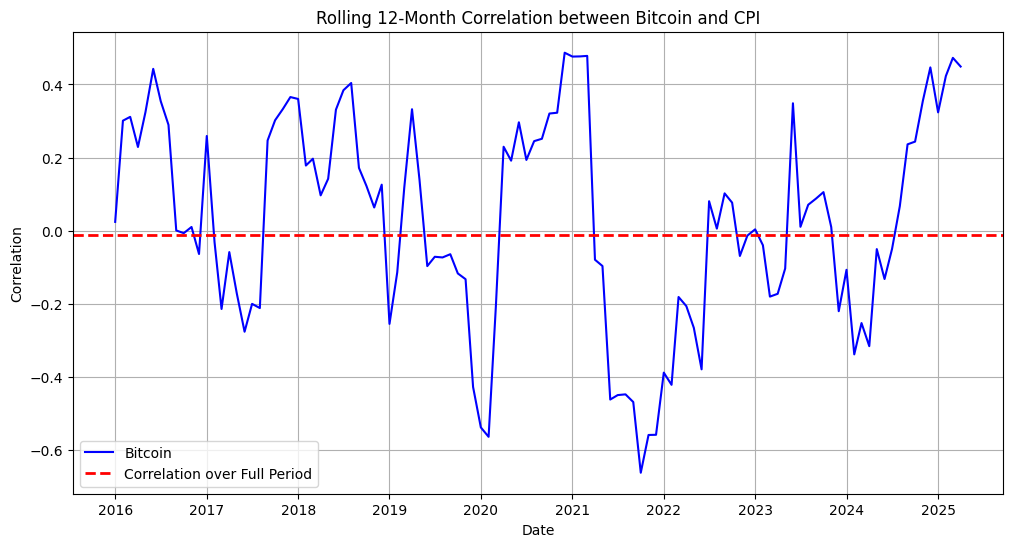

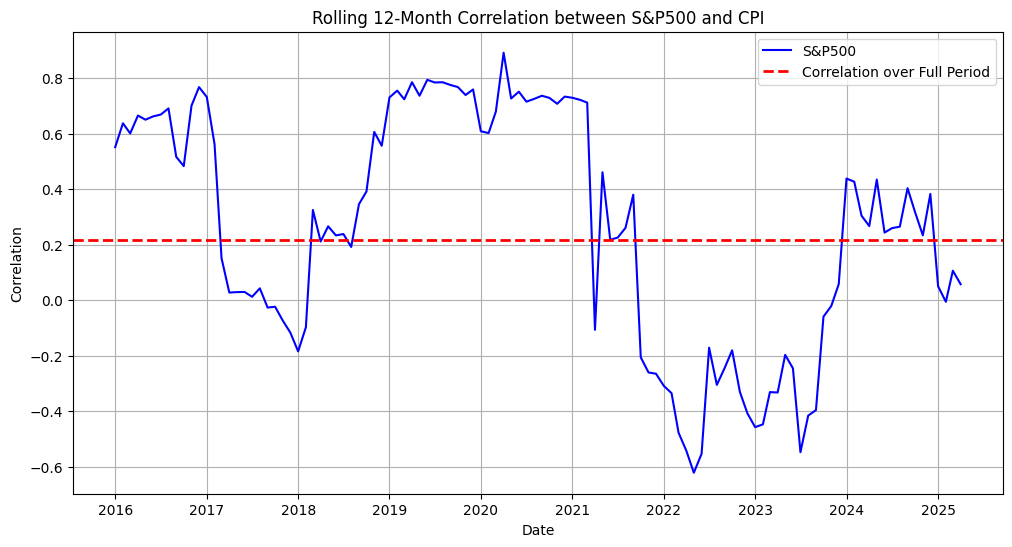

In [111]:
corr_coefs = returns[['Gold', 'SP500', 'Bitcoin']].corrwith(returns['CPI'])
print(returns[['CPI', 'Gold', 'SP500', 'Bitcoin']].corr())
# returns[['CPI', 'Gold', 'SP500', 'Bitcoin']].plot(figsize=(12,6), title="Asset Returns vs Inflation")

plt.figure(figsize=(12,6))

# Plot rolling correlations with labels
rolling_corr_gold = returns['Gold'].rolling(window=12).corr(returns['CPI']).dropna()
rolling_corr_bitcoin = returns['Bitcoin'].rolling(window=12).corr(returns['CPI']).dropna()
rolling_corr_sp500 = returns['SP500'].rolling(window=12).corr(returns['CPI']).dropna()

# Gold vs CPI
plt.figure(figsize=(12, 6))
plt.plot(rolling_corr_gold, label='Gold', color='blue')
plt.axhline(y=corr_coefs['Gold'], color='red', linestyle='--', linewidth=2, label='Correlation over Full Period')
plt.title('Rolling 12-Month Correlation between Gold and CPI')
plt.xlabel('Date')
plt.ylabel('Correlation')
plt.grid(True)
plt.legend()
plt.show()

# Bitcoin vs CPI
plt.figure(figsize=(12, 6))
plt.plot(rolling_corr_bitcoin, label='Bitcoin', color='blue')
plt.title('Rolling 12-Month Correlation between Bitcoin and CPI')
plt.axhline(y=corr_coefs['Bitcoin'], color='red', linestyle='--', linewidth=2, label='Correlation over Full Period')
plt.xlabel('Date')
plt.ylabel('Correlation')
plt.grid(True)
plt.legend()
plt.show()

# S&P500 vs CPI
plt.figure(figsize=(12, 6))
plt.plot(rolling_corr_sp500, label='S&P500', color='blue')
plt.title('Rolling 12-Month Correlation between S&P500 and CPI')
plt.axhline(y=corr_coefs['SP500'], color='red', linestyle='--', linewidth=2, label='Correlation over Full Period')
plt.xlabel('Date')
plt.ylabel('Correlation')
plt.grid(True)
plt.legend()
plt.show()

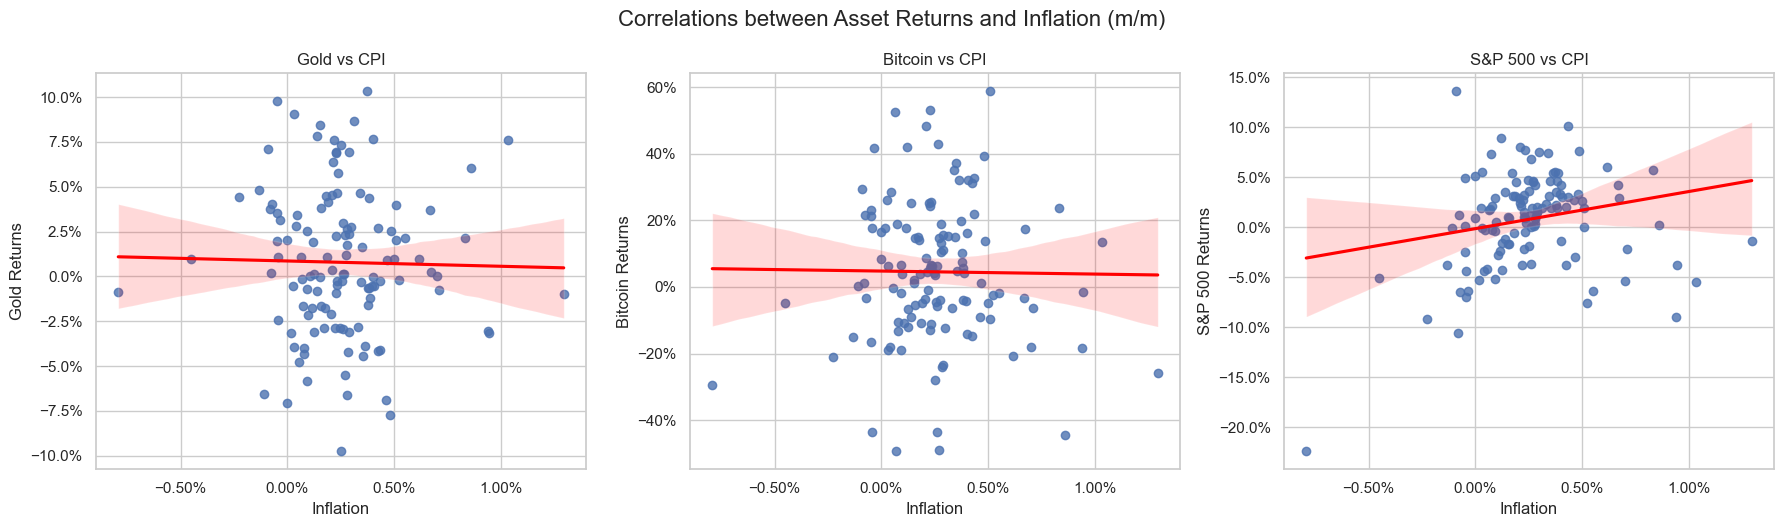

In [119]:
# Set style
sns.set_theme(style="whitegrid")

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Scatter + regression for Gold
sns.regplot(x=returns['CPI'], y=returns['Gold'], ax=axes[0], line_kws={'color': 'red'})
axes[0].set_title('Gold vs CPI')
axes[0].set_xlabel('Inflation')
axes[0].set_ylabel('Gold Returns')

# Scatter + regression for Bitcoin
sns.regplot(x=returns['CPI'], y=returns['Bitcoin'], ax=axes[1], line_kws={'color': 'red'})
axes[1].set_title('Bitcoin vs CPI')
axes[1].set_xlabel('Inflation')
axes[1].set_ylabel('Bitcoin Returns')

# Scatter + regression for S&P 500
sns.regplot(x=returns['CPI'], y=returns['SP500'], ax=axes[2], line_kws={'color': 'red'})
axes[2].set_title('S&P 500 vs CPI')
axes[2].set_xlabel('Inflation')
axes[2].set_ylabel('S&P 500 Returns')

# Format axes as percentages
for ax in axes:
    ax.xaxis.set_major_formatter(PercentFormatter(1.0))
    ax.yaxis.set_major_formatter(PercentFormatter(1.0))

plt.tight_layout()
plt.suptitle('Correlations between Asset Returns and Inflation (m/m)', fontsize=16, y=1.05)
plt.show()

### Forecast Expected Returns

In [26]:
mu2 = expected_returns.mean_historical_return(adj_close_df)
print(mu2)

GLD        0.126536
^GSPC      0.150123
BTC-USD    0.621123
dtype: float64


### Covariance Matrix

In [27]:
cov_matrix = risk_models.sample_cov(adj_close_df)
print(cov_matrix)

              GLD     ^GSPC   BTC-USD
GLD      0.023456  0.003945  0.009755
^GSPC    0.003945  0.031599  0.037454
BTC-USD  0.009755  0.037454  0.370019


### Efficient Frontier

In [28]:
ef = EfficientFrontier(mu2, cov_matrix)
ef.max_sharpe()


OrderedDict([('GLD', 0.5267130313582468),
             ('^GSPC', 0.318881668317748),
             ('BTC-USD', 0.1544053003240052)])

In [29]:
ef.portfolio_performance(verbose=True)

Expected annual return: 21.0%
Annual volatility: 15.9%
Sharpe Ratio: 1.33


(np.float64(0.21042423309834063),
 np.float64(0.15856371388309912),
 np.float64(1.3270642314386987))